In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import PIL
import os
from scipy.special import gamma
import scipy.optimize as optimization

# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import statstuff as sts

# # Development
# from importlib import reload
# reload(sts)

In [2]:
%matplotlib notebook

In [3]:
# Graphics parameters
fontsize = 10
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [4]:
# Set defaults for the analysis
accumlist = [] # This will be all segments unless overridden 

# Only turn this on if we want PDF in terms of Z^2
IwantZ2intervals = True
Iwantlogrintervals = False

if (IwantZ2intervals):
    numforZ2hist = 20
    Z2minforhist = 1e-4; #print(Z2minforhist)
    rmaxforZ2hist = 0.3; Z2maxforhist = 1/(1-rmaxforZ2hist)**2-1; print(Z2maxforhist)
    Z2maxforhist = 1; #print(Z2maxforhist)
    
if (Iwantlogrintervals):
    numforhist = 50
    rminforhist = 1e-7
    rmaxforhist = .6

1.0408163265306127


In [5]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentroot='Segments2'

/Users/nesh/Documents/Repositories/ice4/crystals/2016-06-30_ice1/case1.5
2016-06-30_ice1/case1.5


In [6]:
# Derivative names
Compressedfilename = Segmentroot+'retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentroot+'roughness.jpg'; print(Roughnessfile)
RoughnessZ2file = Segmentroot+'roughnessZ2.jpg'; print(RoughnessZ2file)
Roughnessdatafile=Segmentroot+'roughness.txt'; print(Roughnessdatafile)
Roughnessfitfile=Segmentroot+'roughnessfit.txt'; print(Roughnessfitfile)

Segments2retrieved.npz
Segments2roughness.jpg
Segments2roughnessZ2.jpg
Segments2roughness.txt
Segments2roughnessfit.txt


In [7]:
# Get the retrieved surface
npzfile = np.load(Compressedfilename)
imageroot = np.array_str(npzfile['imageroot'])
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("dx and dy", dx, dy)

dx and dy 1.102431 1.102431


In [8]:
# Setting up windows for where the data are, and the accumulation array
nx1list = npzfile['nx1list']
nx2list = npzfile['nx2list']
ny1list = npzfile['ny1list']
ny2list = npzfile['ny2list']
solution = npzfile['solution']
nsegments = len(nx1list)
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)] 
print('Completed',case) #Prints loading but I wanted to know when it was done.

Completed 2016-06-30_ice1/case1.5


In [9]:
# Graph the segments
im = PIL.Image.open(Filename)
ny_im,nx_im = np.shape(im)
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)
# fig, ax = plt.subplots()
# ax.set_title(Compressedfilename,fontsize=fontsize*0.9)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
# plt.show(im,cmap = 'Greys_r', vmin = 0,vmax = 255)
im.show() # This shouldn't be necessary but there seems to be a bug with plt.show

In [10]:
# Get the histogram as a function of log(r)
if (Iwantlogrintervals):
    newrbins=np.geomspace(rminforhist,rmaxforhist,num=numforhist)
    hbins_total, rbinsW = sts.makehistogram(\
                                 nsegments,nx1list,nx2list,ny1list,ny2list,dx,dy,solution,\
                                 accumlist, newrbins)

In [11]:
# Analysis of this histogram
if (Iwantlogrintervals): 
    # Get the best Weibull fit
    x0 = np.array([0.1])
    fsolution, fsolutionerror = optimization.curve_fit(sts.pGaussianr, rbinsW, hbins_total, x0)
    best_sigmaG = fsolution[0]; 
    print('Gaussian: best_sigma = ', best_sigmaG)

    # Get the best Weibull fit
    x0 = np.array([0.1,1.0])
    fsolution, fsolutionerror = optimization.curve_fit(sts.pWeibullr, rbinsW, hbins_total, x0)
    best_sigmaW = fsolution[0]; 
    print('Weibull: best_sigma = ', best_sigmaW)
    best_eta = fsolution[1]
    print('Weibull: best_eta = ', best_eta)

    # Get the best match for a two-gaussian fit
    x0 = np.array([0.1,0.2,.5])
    fsolution, fsolutionerror = optimization.curve_fit(sts.bimodalfunc, rbinsW, hbins_total, x0)
    best_sigma1 = fsolution[0]
    best_N1 = 1-fsolution[2]
    print('Bimodal: best_sigma1,N1 = ', best_sigma1,best_N1)
    best_sigma2 = fsolution[1]
    best_N2 = fsolution[2]
    print('Bimodal: best_sigma2,N2 = ', best_sigma2,best_N2)
    
        # Get the best-fit distributions
    hbins_gauss = sts.pWeibullr(rbinsW, best_sigmaG, 1)
    R2_G = sts.R_squar(hbins_total,hbins_gauss)
    print('R^2 (Gauss) = ', R2_G)
    hbins_bestfit = sts.pWeibullr(rbinsW, best_sigmaW, best_eta)
    R2_W = sts.R_squar(hbins_total,hbins_bestfit)
    print('R^2 (Weibull) = ', R2_W)
    hbins_bimodal = sts.bimodalfunc(rbinsW, best_sigma1, best_sigma2, best_N2)
    R2_B = sts.R_squar(hbins_total,hbins_bimodal)
    print('R^2 (Bimodal) = ', R2_B)
    
    # Labels for graph
    label_obs = 'obs'
    label_Gauss = 'Gaussian: ' \
                    +'$\sigma$='+str(np.round(best_sigmaG*100)/100) + '\n'\
                    +'$R^2=$'+str(np.round(R2_G*1000)/1000) 
    label_Weibull = 'Weibull: ' \
                    +'$\sigma_W$='+str(np.round(best_sigmaW*100)/100) \
                    +', ' +'$\eta_W$='+str(np.round(best_eta*100)/100) + '\n'\
                    +'$R^2=$'+str(np.round(R2_W*1000)/1000) 

    label_bimodal = 'Bimodal: ' + '\n'\
                    +'$\sigma_1$='+str(np.round(best_sigma1*100)/100) \
                    +', '+'$N_1$='+str(np.round(best_N1*100)/100) + '\n'\
                    +'$\sigma_2$='+str(np.round(best_sigma2*100)/100) \
                    +', '+'$N_2$='+str(np.round(best_N2*100)/100) + '\n'\
                    +'$R^2=$'+str(np.round(R2_B*1000)/1000) 

    # Graph
    plt.figure()
    plt.semilogx(rbinsW,hbins_total,'ok',markersize=5, label=label_obs)
    plt.semilogx(rbinsW,hbins_gauss,'--g',linewidth=2, label=label_Gauss)
    plt.semilogx(rbinsW,hbins_bestfit,'-b',linewidth=2, label=label_Weibull)
    plt.semilogx(rbinsW,hbins_bimodal,'-.m',linewidth=2, label=label_bimodal)
    plt.grid(True)
    plt.xlabel(r'$r$',fontsize=fontsize)
    plt.ylabel(r'$r\rho(r)$',fontsize=fontsize)
    plt.legend(loc='upper left')
    plt.title(case,fontsize=fontsize)
    
    plt.savefig(Roughnessfile)
    dummy= [rbinsW,hbins_total]
    np.savetxt(Roughnessdatafile,dummy)
    cfile = open(Roughnessfitfile,'w')
    cfile.write('&Roughness_Best_Fit\n')
    cfile.write(case+'\n\n'+'Gaussian fit:'+'\n')
    cfile.write('   '+'sigma =' +str(best_sigmaG)+'\n')
    cfile.write('   '+'R^2 ='+str(R2_G)+'\n\n'+'Weibull fit:'+'\n')
    cfile.write('   '+'sigma =' +str(best_sigmaW)+'\n')
    cfile.write('   '+'eta =' +str(best_eta)+'\n')
    cfile.write('   '+'R^2 ='+str(R2_W)+'\n\n'+'Bimodal fit:'+'\n')
    cfile.write('   '+'sigma1 =' +str(best_sigma1)+'\n')
    cfile.write('   '+'N1 =' +str(best_N1)+'\n')
    cfile.write('   '+'sigma2 =' +str(best_sigma2)+'\n')
    cfile.write('   '+'N2 =' +str(best_N2)+'\n')
    cfile.write('   '+'R^2 ='+str(R2_B)+'\n')
    cfile.close()

In [12]:
# Get the histogram as a function of Z2
if (IwantZ2intervals):

    # This calculates a normalized observed PDF as a function of Z^2 (rho(Z^2))
    newZ2bins = np.linspace(Z2minforhist,Z2maxforhist,numforZ2hist)
    newrbins = 1-(1/(newZ2bins+1))**.5

    hbins_total, rbinsW = sts.makehistogram(\
                                 nsegments,nx1list,nx2list,ny1list,ny2list,dx,dy,solution,\
                                 accumlist, newrbins)
    hbins_total = -hbins_total

../../../imagestuff.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(G, z)


Accumulating ... (31, 30) (930,) (930,)
Accumulating ... (31, 30) (930,) (1860,)
Accumulating ... (31, 30) (930,) (2790,)
Accumulating ... (31, 30) (930,) (3720,)
Accumulating ... (31, 30) (930,) (4650,)
Accumulating ... (31, 30) (930,) (5580,)
Accumulating ... (31, 30) (930,) (6510,)
Accumulating ... (31, 30) (930,) (7440,)
Accumulating ... (31, 30) (930,) (8370,)
segment, #pts, <r>, sigma = 0 930 0.024 0.23
segment, #pts, <r>, sigma = 1 930 0.059 0.37
segment, #pts, <r>, sigma = 2 930 0.024 0.23
segment, #pts, <r>, sigma = 3 930 0.017 0.19
segment, #pts, <r>, sigma = 4 930 0.048 0.34
segment, #pts, <r>, sigma = 5 930 0.018 0.2
segment, #pts, <r>, sigma = 6 930 0.016 0.18
segment, #pts, <r>, sigma = 7 930 0.031 0.27
segment, #pts, <r>, sigma = 8 930 0.024 0.23
-136.42890194854098


<IPython.core.display.Javascript object>


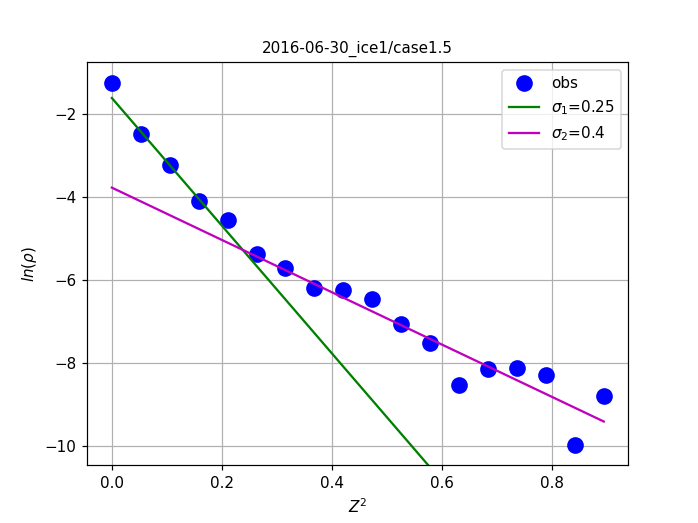

[-15.38125888  -1.6204561 ] predicted sigma1 =  0.2549787919217729
[-6.30066673 -3.78176695] predicted sigma2 =  0.3983884563279954
t1= 14.013307386567226
t2= 20.84344230187029


/Users/nesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app


In [14]:
# Analysis of this histogram
if (IwantZ2intervals):

    # Do some fixing
    ikeep = np.nonzero(hbins_total)
    Z2keep = newZ2bins[ikeep]; #print(Z2keep)
    logrhoZ2 = np.log(hbins_total[ikeep]); #print(logrhoZ2)
    
    # Graph the Z^2 PDF
    plt.figure()
    plt.plot(Z2keep,logrhoZ2,'ob',markersize=10, label='obs')

    # Do some polyfitting
    thisrange = [i for i in range(2,3)]
    p1 = np.polyfit(Z2keep[thisrange],logrhoZ2[thisrange],1)
    best_sigma1 = 1/np.sqrt(-p1[0])
    print(p1,'predicted sigma1 = ', best_sigma1)
    label_sigma1 = '$\sigma_1$='+str(np.round(best_sigma1*100)/100) 
    plt.plot(Z2keep,np.polyval(p1,Z2keep),'g', label=label_sigma1)
    
    n = len(Z2keep)
    thisrange = [i for i in range(n-12,n)]
    p2 = np.polyfit(Z2keep[thisrange],logrhoZ2[thisrange],1)
    best_sigma2 = 1/np.sqrt(-p2[0])
    print(p2,'predicted sigma2 = ', best_sigma2)
    label_sigma2 = '$\sigma_2$='+str(np.round(best_sigma2*100)/100) 
    plt.plot(Z2keep,np.polyval(p2,Z2keep),'m', label=label_sigma2)
        
    # Annotate
    plt.grid(True)
    plt.ylim([np.min(logrhoZ2)-.5,np.max(logrhoZ2)+.5])
    plt.xlabel('$Z^2$')
    plt.ylabel(r'$ln(\rho)$')
    plt.title(case,fontsize=fontsize)
    plt.legend()

    # Save
    plt.savefig(RoughnessZ2file)

    # Reporting
    meanr1 = sts.sigma2meanr(best_sigma1); theta1 = np.arccos(1-meanr1)*180/np.pi; print('t1=',theta1)
    meanr2 = sts.sigma2meanr(best_sigma2); theta2 = np.arccos(1-meanr2)*180/np.pi; print('t2=',theta2)
    